In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import cv2 
from sklearn.cluster import KMeans
from sklearn.svm import SVC

2024-04-22 12:37:00.220275: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 12:37:01.281521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 12:37:05.319547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()



In [4]:
def class_names(index):
    names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if isinstance(index, int):
        return names[index]
    elif isinstance(index, (list, np.ndarray)) and len(index) > 0:
        return names[index[0]]
    else:
        return "Unknown"

In [5]:

# Display dataset information
print("Training set size:", len(train_images))
print("Test set size:", len(test_images))
print("Image shape:", train_images[0].shape)
print("Classes:", np.unique(train_labels))

Training set size: 50000
Test set size: 10000
Image shape: (32, 32, 3)
Classes: [0 1 2 3 4 5 6 7 8 9]


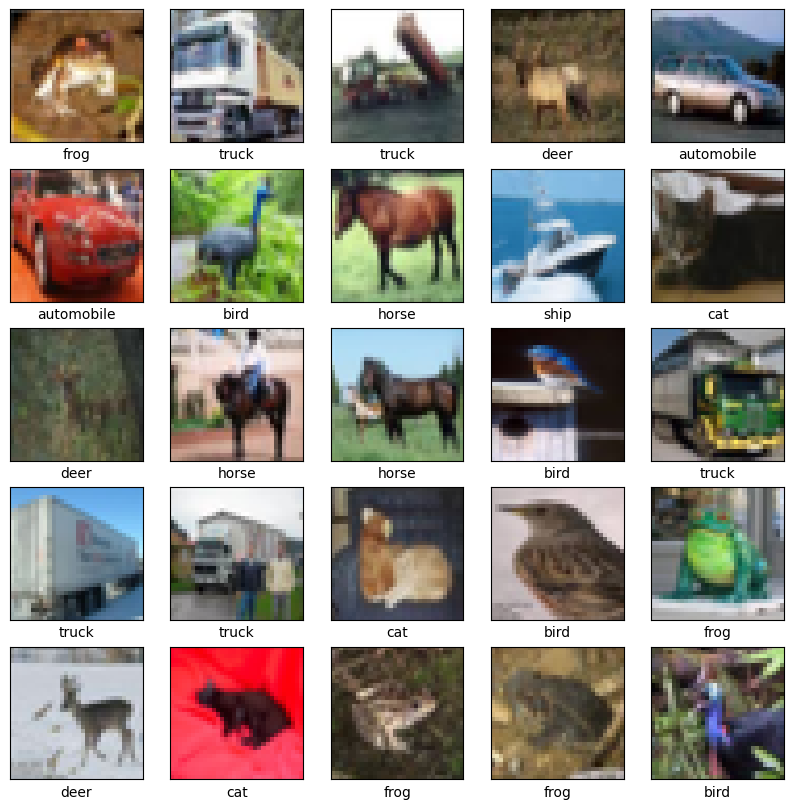

In [6]:
# Visualize some images from the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names(train_labels[i]))
plt.show()



In [7]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract SIFT features for training images
train_descriptors = []
for img in train_images:
    kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
    if des is not None:
        train_descriptors.extend(des)


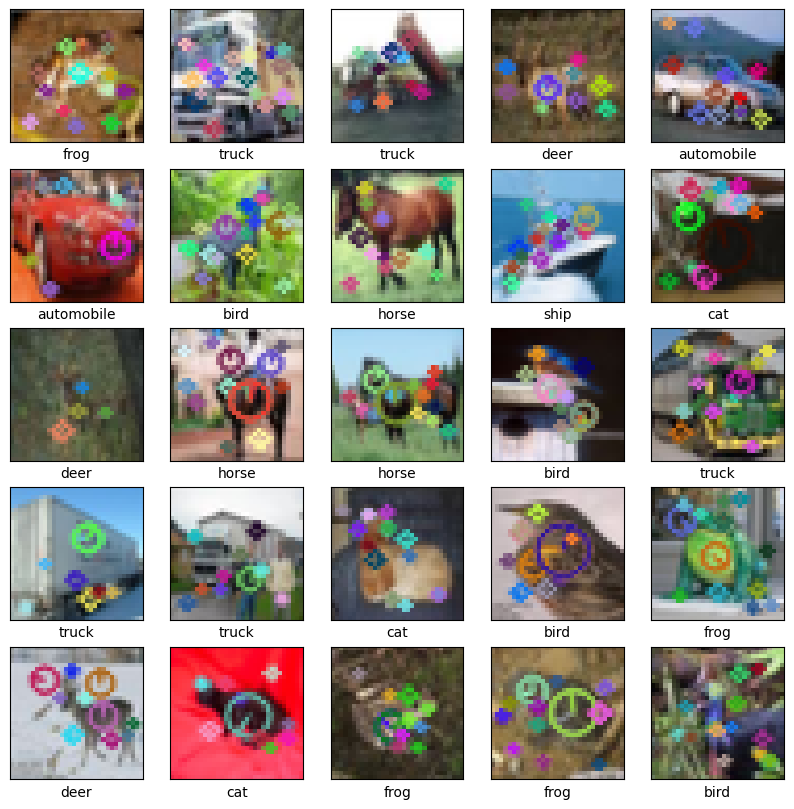

In [8]:
# Visualize SIFT features for a single image from the training set
plt.figure(figsize=(10, 10))
for img_idx in range(25):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(train_images[img_idx], cv2.COLOR_RGB2GRAY)

    # Detect keypoints and compute descriptors
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_img, None)

    # Draw keypoints on the original image
    img_with_sift = cv2.drawKeypoints(train_images[img_idx], kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.subplot(5, 5, img_idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_with_sift)
    plt.xlabel(class_names(train_labels[img_idx]))

plt.show()

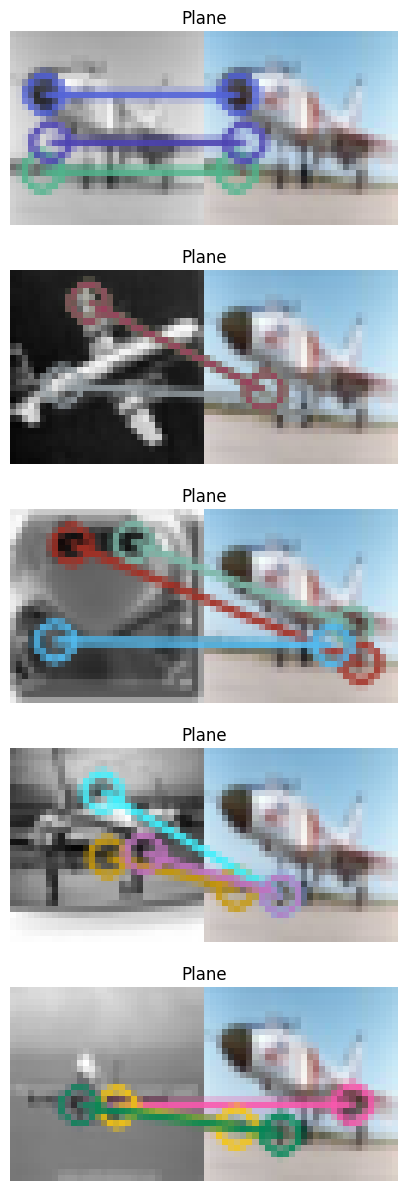

In [19]:
# Filter images and labels corresponding to the "plane" class
plane_indices = [i for i, label in enumerate(train_labels) if class_names(label) == 'airplane']
plane_images = train_images[plane_indices]

# Randomly select 5 images from the "plane" class
random_plane_images = plane_images[np.random.choice(len(plane_images), 5, replace=False)]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the first image in the selected set
gray_first_image = cv2.cvtColor(random_plane_images[0], cv2.COLOR_RGB2GRAY)
kp_first_image, des_first_image = sift.detectAndCompute(gray_first_image, None)

# Create BFMatcher object
bf = cv2.BFMatcher()

# Plot the images
plt.figure(figsize=(5, 15))
for i in range(5):
    gray_img = cv2.cvtColor(random_plane_images[i], cv2.COLOR_RGB2GRAY)

    # Detect keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray_img, None)

    # Match descriptors with the descriptors of the first image
    matches = bf.match(des, des_first_image)

    # Sort matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw matches
    img_matches = cv2.drawMatches(gray_img, kp, random_plane_images[0], kp_first_image, matches[:3], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.subplot(5, 1, i+1)
    plt.imshow(img_matches)
    plt.title('Plane')
    plt.axis('off')
plt.show()

In [20]:
# Convert train_descriptors to a numpy array
train_descriptors_array = np.array(train_descriptors).astype(np.float32)

# Cluster SIFT descriptors into visual words
kmeans = KMeans(n_clusters=100)
kmeans.fit(train_descriptors_array)
visual_words = kmeans.cluster_centers_.astype(np.float32)

In [21]:
# Represent images by histograms of visual word occurrences
def compute_histogram(img):
    kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
    histogram = np.zeros(len(visual_words))
    if des is not None:
        des = des.astype(np.float32)  # Convert descriptors to float32
        labels = kmeans.predict(des)
        for label in labels:
            histogram[label] += 1
    return histogram


In [22]:
train_hist = np.array([compute_histogram(img) for img in train_images])
test_hist = np.array([compute_histogram(img) for img in test_images])

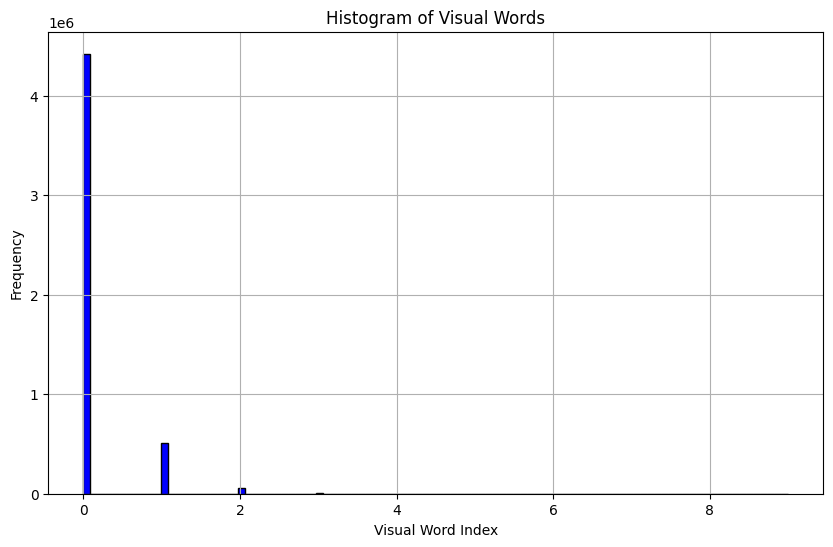

In [23]:
# Plot histogram of visual words
plt.figure(figsize=(10, 6))
plt.hist(np.ravel(train_hist), bins=100, color='blue', edgecolor='black')
plt.title('Histogram of Visual Words')
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [24]:
# Train SVM classifier
svm = SVC()
svm.fit(train_hist, train_labels)

/home/mscrobotics2324laptop14/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [25]:
# Predict labels for test images
pred_labels = svm.predict(test_hist)



In [26]:
# Evaluate classification accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f'Test accuracy: {accuracy}')



Test accuracy: 0.2817


Precision and Recall:
               precision    recall  f1-score   support

    airplane       0.38      0.43      0.40      1000
  automobile       0.30      0.35      0.32      1000
        bird       0.24      0.18      0.21      1000
         cat       0.17      0.12      0.14      1000
        deer       0.19      0.15      0.17      1000
         dog       0.27      0.30      0.28      1000
        frog       0.26      0.25      0.25      1000
       horse       0.28      0.31      0.29      1000
        ship       0.33      0.38      0.36      1000
       truck       0.31      0.34      0.33      1000

    accuracy                           0.28     10000
   macro avg       0.27      0.28      0.28     10000
weighted avg       0.27      0.28      0.28     10000

Confusion Matrix:
 [[427  69  80  27  52  36  36  86 147  40]
 [ 57 346  31  52  47  91  85  51  93 147]
 [191  75 181  60  99  59  90  91 111  43]
 [ 47  83  67 122  99 173 106 112  69 122]
 [ 94  76  88  72 153 115 1

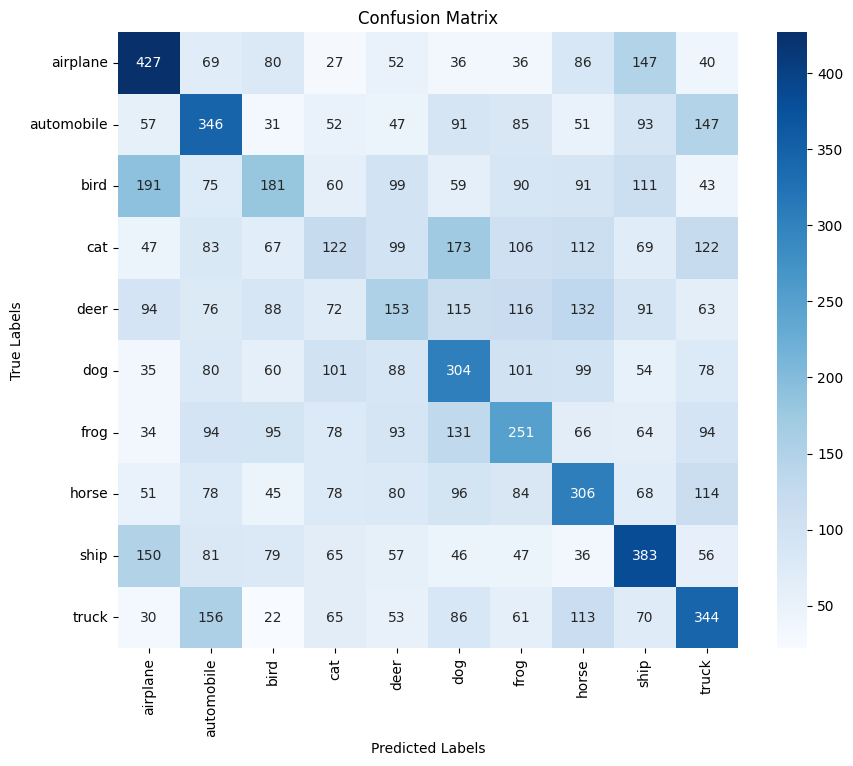

In [27]:
# Calculate precision, recall, and confusion matrix
precision_recall = classification_report(test_labels, pred_labels, target_names=[str(class_names(i)) for i in range(10)])
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Precision and Recall:\n", precision_recall)
print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix with labels using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(class_names(i)) for i in range(10)], yticklabels=[str(class_names(i)) for i in range(10)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()